<a href="https://colab.research.google.com/github/sivasaikiranakula/projects/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load your dataset (update filename if needed)
df = pd.read_csv("/alt_fuel_stations (Mar 25 2025).csv")

# Clean column names
df.columns = df.columns.str.strip()

# Select relevant columns
columns_to_keep = [
    "Fuel Type Code", "Station Name", "City", "State", "ZIP",
    "Latitude", "Longitude",
    "EV Level1 EVSE Num", "EV Level2 EVSE Num", "EV DC Fast Count",
    "Access Days Time", "EV Pricing", "EV Network", "Facility Type"
]
df = df[columns_to_keep]

# Drop rows with missing or invalid location
df = df.dropna(subset=["Latitude", "Longitude"])
df = df[(df["Latitude"] != 0) & (df["Longitude"] != 0)]

# Filter only EV stations
df = df[df["Fuel Type Code"] == "ELEC"]

# Fill missing EV charger numbers with 0
df[["EV Level1 EVSE Num", "EV Level2 EVSE Num", "EV DC Fast Count"]] = df[
    ["EV Level1 EVSE Num", "EV Level2 EVSE Num", "EV DC Fast Count"]
].fillna(0)

# Remove stations with no EV chargers
df = df[
    (df["EV Level1 EVSE Num"] > 0) |
    (df["EV Level2 EVSE Num"] > 0) |
    (df["EV DC Fast Count"] > 0)
]

# Reset index
df_cleaned = df.reset_index(drop=True)

df_cleaned.to_csv("cleaned_ev_stations.csv", index=False)



In [ ]:
# Create a new feature: Total Chargers
df_cleaned["Total Chargers"] = (
    df_cleaned["EV Level1 EVSE Num"] +
    df_cleaned["EV Level2 EVSE Num"] +
    df_cleaned["EV DC Fast Count"]
)

# Create a simplified Access Type category
df_cleaned["Access Type"] = df_cleaned["Access Days Time"].apply(
    lambda x: "24/7" if isinstance(x, str) and "24" in x else "Limited"
)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define input and output
X = df_cleaned.drop(columns=["EV Level2 EVSE Num", "Fuel Type Code"])
y = df_cleaned["EV Level2 EVSE Num"]  # or "Total Chargers" if you prefer

# Select column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipelines
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_cols),
    ("cat", cat_pipe, categorical_cols)
])

# Model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 0.29995621149354335
R²: 0.9885317264738192


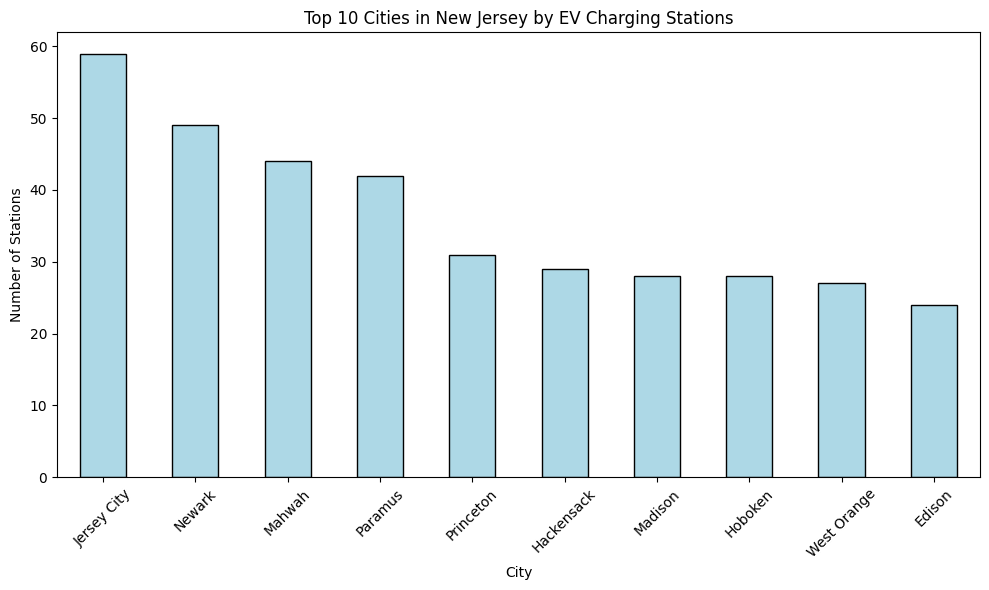

In [ ]:
top_cities = df_cleaned["City"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
top_cities.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Top 10 Cities in New Jersey by EV Charging Stations")
plt.xlabel("City")
plt.ylabel("Number of Stations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


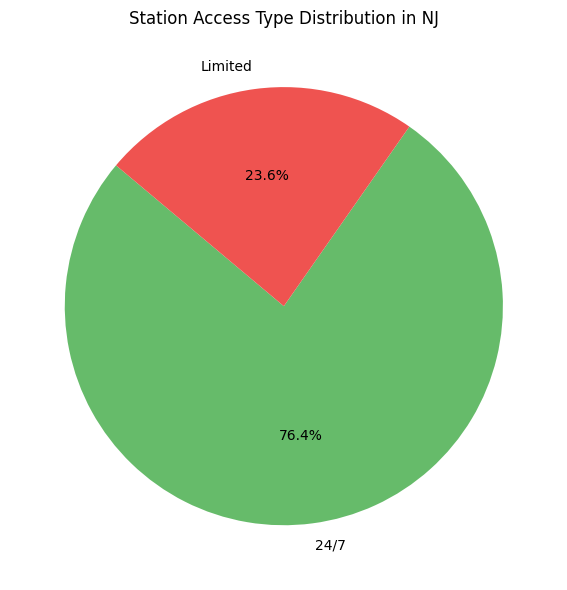

In [ ]:
access_type_counts = df_cleaned["Access Type"].value_counts()

plt.figure(figsize=(6, 6))
access_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#66bb6a', '#ef5350'])
plt.title("Station Access Type Distribution in NJ")
plt.ylabel("")
plt.tight_layout()
plt.show()


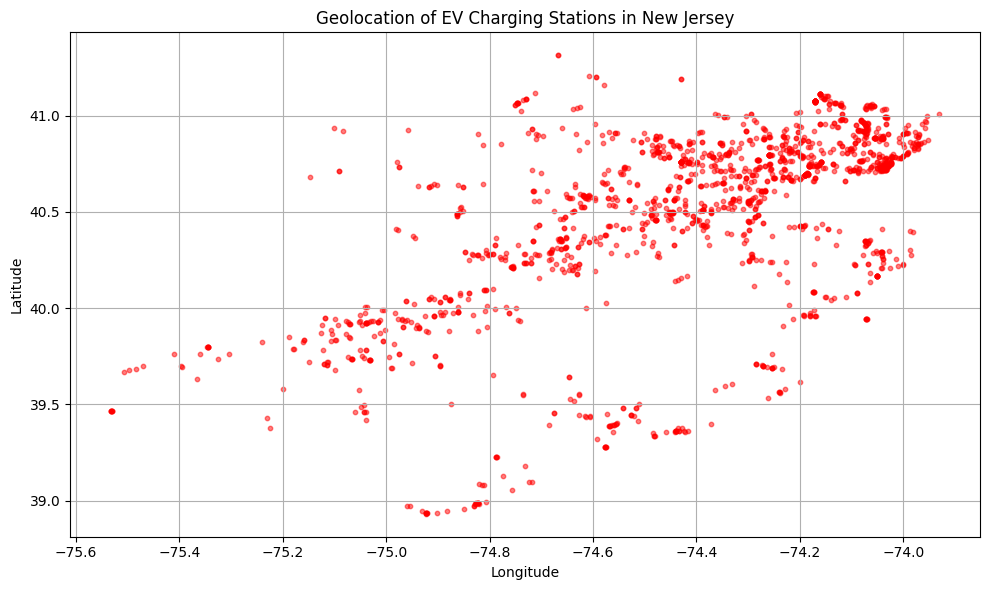

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned["Longitude"], df_cleaned["Latitude"], alpha=0.5, c="red", s=10)
plt.title("Geolocation of EV Charging Stations in New Jersey")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


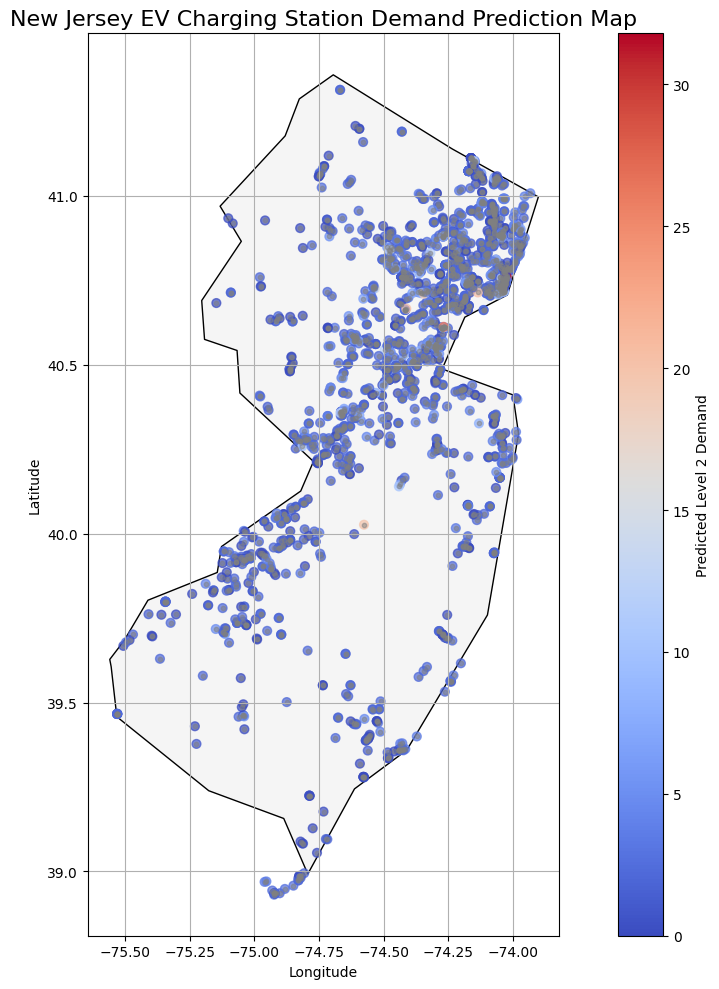

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Load the cleaned data with predictions
df = pd.read_csv("cleaned_ev_stations.csv")

# Prepare features and target
X = df.drop(columns=["EV Level2 EVSE Num"])
y = df["EV Level2 EVSE Num"]

categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_cols),
    ("cat", cat_pipe, categorical_cols)
])

# Model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train and predict
model.fit(X, y)
df["Predicted Level2 Demand"] = model.predict(X)

# Create GeoDataFrame from coordinates
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load US states and filter for New Jersey
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
us_states = gpd.read_file(url)
new_jersey = us_states[us_states["name"] == "New Jersey"]

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
new_jersey.plot(ax=ax, color="whitesmoke", edgecolor="black")
gdf.plot(
    ax=ax,
    column="Predicted Level2 Demand",
    cmap="coolwarm",
    markersize=40,
    alpha=0.7,
    legend=True,
    legend_kwds={"label": "Predicted Level 2 Demand"}
)

plt.title("New Jersey EV Charging Station Demand Prediction Map", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
# OPTIONAL: Load and plot actual stations with city names
existing_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"
)

# Plot existing stations (optional small gray dots)
existing_points.plot(ax=ax, color="gray", markersize=10, alpha=0.5)

# Annotate city names (once per city)
# for city, row in df.groupby("City").first().iterrows():
#     plt.text(
#         row["Longitude"], row["Latitude"], city,
#         fontsize=8, color="black", weight="bold",
#         ha='center', va='center'
#     )

plt.show()


In [ ]:
pip install geopandas matplotlib

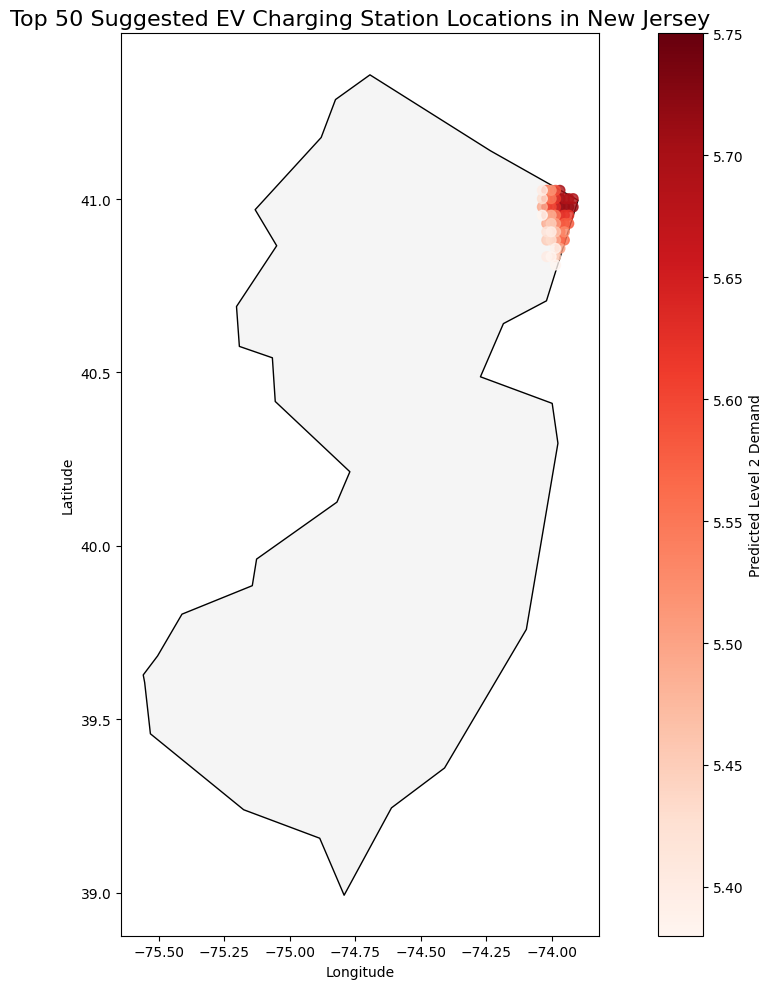

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Step 1: Load New Jersey Boundary
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
us_states = gpd.read_file(url)
new_jersey = us_states[us_states["name"] == "New Jersey"]
nj_boundary = new_jersey.geometry.iloc[0]

# Step 2: Generate grid points across NJ
minx, miny, maxx, maxy = nj_boundary.bounds
x_coords = np.linspace(minx, maxx, 100)
y_coords = np.linspace(miny, maxy, 100)

grid_points = []
for x in x_coords:
    for y in y_coords:
        p = Point(x, y)
        if nj_boundary.contains(p):
            grid_points.append(p)

grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs="EPSG:4326")
grid_df = pd.DataFrame({
    "Longitude": [pt.x for pt in grid_points],
    "Latitude": [pt.y for pt in grid_points]
})

# Step 3: Add required default attributes
grid_df["Fuel Type Code"] = "ELEC"
grid_df["Station Name"] = "Predicted Location"
grid_df["City"] = "Unknown"
grid_df["State"] = "NJ"
grid_df["ZIP"] = 0
grid_df["EV Level1 EVSE Num"] = 0
grid_df["EV DC Fast Count"] = 0
grid_df["Access Days Time"] = "24 hours daily"
grid_df["EV Pricing"] = "Free"
grid_df["EV Network"] = "Non-Networked"
grid_df["Facility Type"] = "PARKING_GARAGE"

# Ensure same column order as training data (X.columns)
required_columns = X.columns
for col in required_columns:
    if col not in grid_df.columns:
        grid_df[col] = "Unknown" if col in categorical_cols else 0

grid_df = grid_df[required_columns]  # Reorder columns to match training

# Step 4: Predict demand at new points
grid_df["Predicted Level2 Demand"] = model.predict(grid_df)

# Step 5: Merge with geometry and filter top demand
grid_gdf["Predicted Level2 Demand"] = grid_df["Predicted Level2 Demand"]
top_demand_gdf = grid_gdf.sort_values("Predicted Level2 Demand", ascending=False).head(50)

# Step 6: Plot New Jersey map with top 50 predicted points
fig, ax = plt.subplots(figsize=(12, 10))
new_jersey.plot(ax=ax, color="whitesmoke", edgecolor="black")
top_demand_gdf.plot(
    ax=ax,
    column="Predicted Level2 Demand",
    cmap="Reds",
    markersize=50,
    legend=True,
    legend_kwds={"label": "Predicted Level 2 Demand"},
    alpha=0.8
)

plt.title("Top 50 Suggested EV Charging Station Locations in New Jersey", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load your data
df = pd.read_csv("cleaned_ev_stations.csv")

# Filter only New Jersey (if needed)
df = df[df["State"] == "NJ"]

# Count number of stations per city
city_counts = df["City"].value_counts().head(50)

# Display as a DataFrame
top_50_cities = city_counts.reset_index()
top_50_cities.columns = ["City", "Number of Stations"]

print(top_50_cities)


                     City  Number of Stations
0             Jersey City                  59
1                  Newark                  49
2                  Mahwah                  44
3                 Paramus                  42
4               Princeton                  31
5              Hackensack                  29
6                 Madison                  28
7                 Hoboken                  28
8             West Orange                  27
9                  Edison                  24
10            Cherry Hill                  19
11             Piscataway                  19
12         East Brunswick                  18
13          New Brunswick                  18
14              Elizabeth                  16
15               Montvale                  16
16    Egg Harbor Township                  15
17            Bridgewater                  15
18      Hamilton Township                  15
19               Secaucus                  15
20          Atlantic City         

Total predicted points: 21357


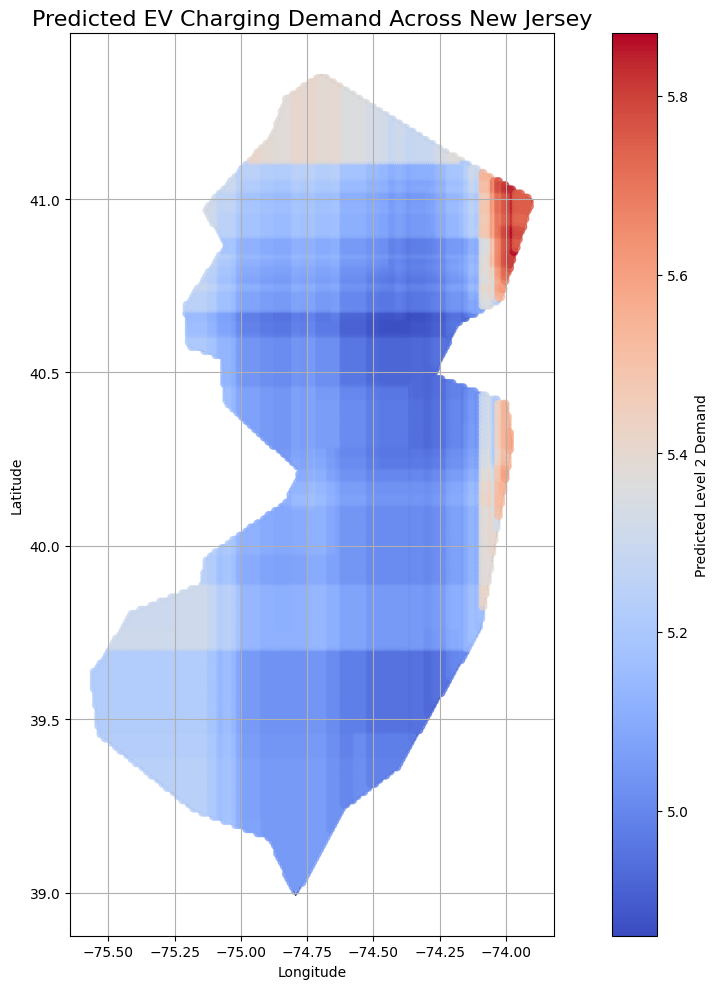

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Step 1: Load NJ boundary
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
us_states = gpd.read_file(url)
new_jersey = us_states[us_states["name"] == "New Jersey"]
nj_geom = new_jersey.geometry.iloc[0]

# Step 2: Generate dense grid points within NJ boundary
minx, miny, maxx, maxy = nj_geom.bounds
x_coords = np.linspace(minx, maxx, 200)  # increase density by changing 200
y_coords = np.linspace(miny, maxy, 200)

grid_points = [Point(x, y) for x in x_coords for y in y_coords if nj_geom.contains(Point(x, y))]
print(f"Total predicted points: {len(grid_points)}")

# Step 3: Create DataFrame with mock/default values
grid_df = pd.DataFrame({
    "Longitude": [pt.x for pt in grid_points],
    "Latitude": [pt.y for pt in grid_points]
})

# Set default or median values for all required features
for col in X.columns:
    if col not in grid_df.columns:
        if col in categorical_cols:
            grid_df[col] = "PARKING_GARAGE"  # or most common category
        elif col == "State":
            grid_df[col] = "NJ"
        elif col == "Fuel Type Code":
            grid_df[col] = "ELEC"
        elif col == "Access Days Time":
            grid_df[col] = "24 hours daily"
        elif col == "EV Pricing":
            grid_df[col] = "Free"
        elif col == "EV Network":
            grid_df[col] = "Non-Networked"
        else:
            grid_df[col] = 0  # default for numeric fields

# Reorder to match training input
grid_df = grid_df[X.columns]

# Step 4: Predict demand
grid_df["Predicted Level2 Demand"] = model.predict(grid_df)

# Step 5: Create GeoDataFrame
geometry = [Point(xy) for xy in zip(grid_df["Longitude"], grid_df["Latitude"])]
grid_gdf = gpd.GeoDataFrame(grid_df, geometry=geometry, crs="EPSG:4326")

# Step 6: Plot all predictions on NJ map
fig, ax = plt.subplots(figsize=(12, 10))
new_jersey.plot(ax=ax, color="white", edgecolor="black")
grid_gdf.plot(
    ax=ax,
    column="Predicted Level2 Demand",
    cmap="coolwarm",
    markersize=30,
    legend=True,
    legend_kwds={"label": "Predicted Level 2 Demand"},
    alpha=0.7
)

plt.title("Predicted EV Charging Demand Across New Jersey", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()
